<a href="https://colab.research.google.com/github/ValKhv/AMNEZIA-2/blob/main/LinkageAttackSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#МЕТРИКИ ПРИВАТНОСТИ И СИМУЛЯЦИЯ LINKAGE-АТТАКИ
В данном ноутбуке мы исследуем вопрос защищенности наборо с персональными данными  - с учетом "*ранее утекших*" наборов данных. В процессе симуляции (*крипто-игры*) мы рассчитаем необходимые характеристики, позволяющие оценить для исходных наборов уровень защищенности после соответсвующих преобразований по обезличиванию информации, а также вероятность нахождения пересечения со сторонним набором данных.
Здесь мы приводим алгоритмы и основные результаты, даем пояснения, для более точной информации рекомендуем ознакомиться со следующими источниками:
- [АБД, Рекомендации по использованию методов обезличивания](https://app.box.com/s/f1aljgdj6zd3j9crbfb2alxbtb71tbjn), 2023.
- Tânia Carvalho, Nuno Moniz, Pedro Faria, and Luís Antunes. 2022. Survey on Privacy-Preserving Techniques for Data Publishing. 1, 1
(January 2022), 35 pages. https://doi.org/10.1145/1122445.1122456

Все имеющие данные представляют собой синтетические наборы и описывают вымышленных физических лиц.

##1. ВВЕДЕНИЕ
###1.1 Основные понятия
В процессе симуляции мы делаем ряд предположений и осуществляем практическую попытку проведения атаки на синтетические наборы. Несмотря на умозрительный характер предположений наши действия похожи на реальный сценарий атак на приватные данные. Такой подход часто называется крипто-игрой.

Защита персональных данных - достаточно емкая проблема, применение методов зависит от сценария обмена (публикации) данных, предположений о модели злоумышленника, поверхности атак. Мы предполагаем, что потенциальный злоумышленник владеет необходимыми знаниями и ресурсами для проведения сложных атак. Исследуемый способ защиты представляет собой относительно простые манипуляции с исходными данными, основанными преимущественно на искажении исходных данных: замена имен, незначительные сдвиги дат, сумм, замена адресов и т.п.
####1.1.1 Типы атрибутов
Анализируя данные на предмет их безопасности, мы учитывая табличный характер информации, будем оперировать атрибутами (столбцами), с помощью которых можно привязать запись (строку в таблице) к конкретному ФЛ. Различают следующие атрибуты:
- **Прямые идентификаторы**: такие атрибуты, которые прямо указывают на конкретное, например, номер телефона или номер и серия паспорта.
-**Квази-идентификаторы**: атрибуты, которые не указывают по отдельности на какое-то ФЛ, но в свокупности также позволяют выделить из набора ФЛ. Например, сочетание возраста, региона, пола, профессии, каких-то иных регионов может выделить из набора специфическую запись и првязать ее к ФЛ.
-**Чувствительные атрибуты**: атрибуты, которые содержат описание ФЛ, его характеристики, такие как зарплата, баланс на счету и т.п.

Выбор типа атрибутов как правило совершается в процессе анализа набора данных и может иметь варианты. Оставляя за скобками ноутбука методику выбора типа атрибутов (особенно квази-идентификаторов) отметим, что в процессе защиты набора данных выполняются преобразования, нацеленные на разрушение связей между записями и конкретными ФЛ, "*размывая*" исходный набор для снижения риска повторной идентификации:  
-**Риск повторной идентификации** отражает вероятность того, что конкретное ФЛ моожет быть установлено (идентифицировано) в анонимизированном наборе.  Иными словами, это мера того насколько легко можно связать анонимные данные с их сиходными владельцами, несмотря на усилия по сокрытию или изменению идентифицирующих признаков.

В результате мер по защите данных вместо исходного набора возникает "защищенный" набор, который выглядит как набор новых записей, внешне не связанным с исходным набором. Однако, поскольку набор готовится для определенных целей исследования, искажения не могут быт очень сильными - в противном случае нарушаются корреляции и могут быть сформированы неправильные выводы.

####1.1.2 Метрики безопасности
Противоречие между степенью защищенности и степенью безопасности приводит к задаче количественной оценке проблемы: достаточно ли набор защищен, чтобы оставаться безопасным и остается ли при этом он все еще полезным для практических задач. Это решается с помощью известной модели k-Anonymity, которая использует следующие метрики безопасности (Privacy):
- **k-anonymity**: эта метрика гарантирует, что каждая запись в наборе, описывающая конкретное ФЛ, неотличима от как минимум $(k-1)$ других записей в том же наборе данных. Таким образом, нельзя точно сказать, идет ли речь о конкретном человеке или других людей из той же группы. Такие группы также называются **классами эквивалентности**.
- **ℓ-diversity**: эта метрика представляет собой расширение *k-anonymity* и гарантирует, что для каждой группы (класса эквивалентности), которая имеет определённую k-anonimity, существуют как минимум  ℓ "разнообразных" значений для чувствительных атрибутов. Такая метрика защищает чувствительные атрибуты, по которым также можно вычислить определенное ФЛ (например, точное значение суммы на счету).

Существуют и другие метрики приватности, однако, для практических целей ограничимся только k-anonymity и ℓ - diversity. Искомая вероятность повторной идентификации для данных $P_{data}$:
$$P_{data}=\frac{1}{<f>} \tag{1}$$

Здесь $<f>$ - минимальный показатель метрики $k$ или $ℓ$ для всех классов эквивалентности "защищенного" набора. Например, при минимальном показателе $k-anonymity=2$ вероятность повторной идентификации составит $P_{data}= \frac{1}{2} = 0.5$



####1.1.3 Метрики полезности
Как было отечено выше, чем безопаснее набор (то есть, чем большие значения k-anonymity в наборе), тем меньше его полезность (Utility) для конечных целей. Существует много способов оценки полезности, здесь ограничимся следующими:
- **Потеря информации** (**Information Loss**): снижение информационной ценности набора, которое будем оценивать с помощью метода **NSSD** (*Normalized Sum of Squared Differences*, нормализованная сумма квадратов разности). Этот метод измеряет сумму квадратов разностей в исходной и защищенной (анонимизированной) таблице. С помощью NSSD можно измерить потерю точности (**Precission Loss**), то есть насколько новые данные изменены счет вносимого шума и соответсвенно, стали неточными. Для каждого $i-$того атрибута исходного (ordinary) и анонимизированного (anonymized) набора величина метрики NSSD будет представлена формулой:
$$NSSD_i=\frac{1}{n\cdot (max_i-min_i)^2)}\sum_{j=1}^n (D_{o_{ij}}-D_{a_{ij}})^2) \tag2$$
<center><small>Здесь $D_{o_{ij}}$ - значение $j-$ой строки $i-$того атрибута в оригинальном наборе, а $D_{a_{ij}}$ - соответствующая величина  $j-$ой строки $i-$того атрибута в анонимизированном наборе, $max_i$ и $min_i$ максимельное и минимальное значение $i-$того атрибута в оригинальном наборе, $n$ - количество записей в обоих наборах. </small></center>

Общий коэффицент NSSD может быть представлен формулой:
$$NSSD_{total}=\frac{1}{\sum_{i=1}^{m} NSSD_i} \tag3$$
- **Потеря корреляции** (**Correlation Loss Metric, CLM**), изерение корреляционной структуры данных до и после анонимизации. Мы будем измерять это с помощью коэффициента Пирсона:
$$r=\frac{\sum_{i=1}^n (x_i - \overline{x})(y_i-\overline{y})}{\sqrt{\sum_{i=1}^n (x_i-\overline{x})^2 \sum_{i=1}^n (y_i-\overline{y})^2))}} \tag4$$

<center><small>Здесь $x_i$,$y_i$ - значения двух атрибутов $i$-той строки, а $\overline{x}$ и $\overline{y}$ - их средние значtния. </small>

Метрика Пирсона измеряется для исходного и обезличенного набора, конечное значение метрики $CLM$:
$$CLM=|r_{original} - r_{anonymized}| \tag5$$  

####1.1.4 Виды атак
**Атаки** на защищенные наборы данных относятся к методам, с помощью которых злоумышленник может получить несанкционированный доступ к личной или конфиденциальной информации, которая должна быть защищена, часто, насмотря на усилия по анонимизации данных. Эти атаки используют слабые места или "**поверхности атаки**" в методах анонимизации или более широкой среде данных для повторной идентификации людей или раскрытия конфиденциальной информации. "*Поверхность атаки*" в этом контексте представляет собой сумму различных точек (**векторов атаки**), в которых неавторизованный пользователь может попытаться ввести или извлечь данные.

Разные профили злоумышленника могут иметь разную мотивацию и ресурсы для проведения таких атак:
- **Прокурор** (**Prosecutor**): Мотивированный злоумышленник, который ищет конкретного человека в наборе данных. Этот тип злоумышленников знает, что конкретный человек включен в набор данных, и пытается повторно идентифицировать его запись. Например, если некоторые записи в наборе данных имеют k-анонимность, равную 1, означающую, что они уникальны и легко различимы, *прокурор* может использовать **дополнительные знания** для проведения атаки на членство (**membership attack**) и с высокой степенью уверенности подтвердить присутствие человека в наборе данных, а после и извлечь значения чувствительных атрибутов.
-**Журналист** (**Journalist*): Как правило, заинтересованный в поиске истории о ком-то (не обязательно о ком-то конкретном), журналист может попытаться выявить закономерности или **идентифицировать нескольких человек** в наборе данных, чтобы раскрыть более широкие проблемы или истории. Такие злоумышленники могут быть заинтересованы не в одном человеке, а в выявлении тенденции или недостатка в процессе анонимизации, который имеет социальные последствия.
- **Маркетолог** (**Marketer**): Такие злоумышленники могут стремиться **идентифицировать потенциальных клиентов** из анонимного набора данных для таргетированной рекламы. Маркетологи могут быть заинтересованы не в точной идентификации людей, а в деанонимизации достаточного количества информации, чтобы обеспечить эффективную сегментацию рынка.

Несмотря на цивильные названия (Прокурор, Журналист, Маркетолог) такие злоумышленники могут преследовать нелегальные цели, связанные с вымогательством, компрометацией или построения более сложных атак с использованием социальной инженерией.

С точки зрения данной задачи крипто-игры мы можем выделить две важные атаки:
- **Атаки выдачи/выделения** (**Allocation Attack**):  в рамках таких атак злоумышленник может выделить (или «отобразить») анонимную запись обратно к отдельному лицу. Атаки с распределением часто используют наборы данных с низкой k-анонимностью (например, при $k=1$, что означает, что существуют записи, которые являются уникальными или отличными друг от друга на основе квазиидентификаторов). Если злоумышленник может догадаться или узнать из других источников, что данные человека, вероятно, включены в набор, он может подтвердить свое присутствие с помощью так называемой атаки на членство. Уникальность записи о человеке в наборе данных фактически лишает его защиты, обеспечиваемо
- **Атаки связывания** (**Linkage Attack**):  Атака связывания включает в себя объединение анонимного набора данных с одним или несколькими внешними наборами данных для идентификации отдельных лиц. Это может произойти даже при более высокой k-анонимности, если внешний набор данных обладает достаточной детализацией. Например, предположим, что существует анонимный набор данных медицинских карт пациента и отдельный, незащищенный набор данных из приложения для здоровья, который включает аналогичные атрибуты здоровья. Злоумышленник может искать записи, которые совпадают в обоих наборах данных, чтобы идентифицировать людей в анонимизированном наборе. При наличии достаточного совпадения квазиидентификаторов (таких как возраст, почтовый индекс и пол) даже анонимные записи могут быть связаны с конкретными лицами в незащищенном наборе данных.


Для защиты от таких атак важно использовать надежные методы анонимизации и учитывать потенциальную «поверхность атаки» в процессе анонимизации. Более высокие значения k-анонимности, l-разнообразия (обеспечение разнообразия чувствительных атрибутов внутри групп) и t-близости (сохранение распределения чувствительных атрибутов близким к общему распределению) могут усилить защиту. Кроме того, регулярные аудиты, моделирование угроз для прогнозирования потенциальных атак и поддержание в актуальном состоянии новейших методов обеспечения безопасности имеют решающее значение для поддержания конфиденциальности и целостности анонимных наборов данных.

##1.2 Моделируемый сценарий
В рамках крипто-игры мы рассматриваем условно следующую ситуацию:

1)  Один из участников - <mark>финансовая организация (БАНК)</mark> пытается провести **анализ оттока клиента (Churn analysis)**. Такой анализ включает в себя изучение поведения клиентов, истории транзакций, взаимодействия с банковскими сервисами и других демографических и психографических данных для выявления закономерностей или индикаторов того, что клиент, скорее всего, закроет свой счет или перестанет пользоваться услугами банка. Поэтому БАНК подготовливает широкий набор данных по группе клиентов <mark>**BANKCHURNE**</mark>, который включает разнообразные атрибуты. Не имея собственных ресурсов для построения ML/AI модели, БАНК хочет привлечь для этой работы подрядчика. В этих целях обучающая выборка подвергается специальной обработке - анонимизации: в результате которой заменяются имена и фамилии,незначительно сдвигаются даты рождения, подменяются адрес и другие атрибуты (паспорт, телефон и т.п.).  В результате возникает анонимизированный набор <mark>**MASK**</mark>.Мы ислледуем ситуацию "**наивного преобразования**", при котором метрики безопансости не принимаются в расчет, БАНК лишь рандомизирует значения в некотором диапазоне, стремясь к формальным отличиям.

2) <mark>Подрядчик банка (**MODELL DEVELOPER**)</mark> получает анонимизированный набор, на основе которого собирается построить CHURN-модель. Однако, в штате подрядчика находится коррумпированный сотрудник, который передает анонимизированный набор **MASK** на сторону - злоумышленнику.

3) <mark>Злоумышленник (**HACKER**)</mark> не только знает, что в наборе находится некоторая группа известных ему людей, которых можно вычислить непосредственно по набору (**ALLOCATION ATTACK**), но и использует ранее утекший <mark>набор по интернет-доставке из магазинов электронной коммерции **DELIVERY**</mark>. Набор **DELIVERY** значительно более широкий, чем исходный набор **BANKCHURNE** и  анонимизированный **MASK**, так что можно предположить, что между наборами имеются пересечения. Хотя большая часть атрибутов набора **DELIVERY** отличается, некоторые атрибуты являются общими, так что можно попытаться найти по ним пересечение и даже обогатить информацию о найденных клиентах, например, восстановив, ранее замененный на случайное значение адрес, индекс и даже телефон. Кроме того, новые атрибуты, такие как заказанные товары помогут в дальнейшем использовать социальную инженерию, разыграв клиента магазина с его банковским аккаунтом  (на основе **CHURNE** ) и недавно купленным товаром (по **DELIVERY**).

Рассмотренный сценарий представлен на схеме ниже.




![](https://drive.google.com/uc?export=view&id=1wfX3OjVuj8n-xcmBnFE7YJ2xzUkwz2hQ)

###1.3  Наборы данных
В оответствии с постановкой задачи, изложенной выше, внутри сценария фигурирут три набора данных:
<ol start="1">
<li><b>CHURNE</b> - набор данных, изначально подготвленный Банком с открытыми значениями всех атрибутов, 2 000 записей. Атрибуты набора: </li>
     <ul>
        <li><i>FIO</i> - Фамилия, Имя и Отчество ФЛ, клиента БАНКА</li>
        <li><i>DoB</i> - Дата рождения клиента</li>
        <li><i>SEX</i> - Пол клиента</li>
        <li><i>Passport<i> - Серия и номер паспорта</li>
        <li><i>CardNumber</i> - Номер кредитной карты</li>
        <li><i>AvailableTill</i> - Кредитная карта валидна до ... </li>
        <li><i>BALLANCR</i> - Баланс по счету карты</li>
        <li><i>CurrentDate</i> - Текущая дата</li>
        <li><i>Phone</i> - Номер мобильного телефона клиента</li>
        <li><i>WorkAddress</i> - Рабочий адрес клиента</li>
        <li><i>WorkPlace</i> - Место работы клиента</li>
        <li><i>ZIP</i> - Почтовый код клиента</li>
        <li><i>REGION</i> - Регион места проживания клиенат</li>
        <li><i>CITY</i> - Город/Населенный пункт проживания клиента</li>
        <li><i>STREET</i> - Адрес клиента (улица, дом, квартира)</li>
        <li><i>PROFESSION</i> - Профессия клиента, сведения из анкеты</li>
        <li><i>CreditScore</i> - Кредитный скоринг клиента</li>
        <li><i>TotalTxs</i> - Общее количество транзакций клиента на момент выгрузки</li>
     </ul>   
<li><b>MASK</b> - обработанный (анонимизированный) набор данных на 2 000 записей с таким же составом атрибутов (выделены те атрибуты, которые подверглись преобразованию): </li>
     <ul>
        <li><i><mark>FIO</mark></i> - Заменено на случайное значение с учетом пола</li>
        <li><i><mark>DoB</mark></i> - Заменено на случайное в заданном диапазоне</li>
        <li><i>SEX</i> - Пол клиента сохранен</li>
        <li><i><mark>Passport</mark><i> - Серия и номер паспорта изменены на новые значения с учетом региона</li>
        <li><i><mark>CardNumber</mark></i> - Номер кредитной карты изменен за исключением банковского идентификатора</li>
        <li><i><mark>AvailableTill</mark></i> - Дата изменена в пределах заданного диапазона</li>
        <li><i><mark>BALLANCR</mark></i> - Сумма изменена на случайную</li>
        <li><i><mark>CurrentDate</mark></i> - Текущая дата изменена в пределах диапазона</li>
        <li><i><mark>Phone</mark></i> - Изменен в пределах диапазона</li>
        <li><i><mark>WorkAddress</mark></i> - Изменен на случайное значение</li>
        <li><i><mark>WorkPlace</mark></i> - Адрес в пределах региона</li>
        <li><i><MARK>ZIP</mark></i> - Изменен в пределах региона</li>
        <li><i>REGION</i> - Без изменения</li>
        <li><i><mark>CITY</mark></i> - Изменен в пределах региона</li>
        <li><i><mark>STREET</mark></i> - Изменен в пределах региона</li>
        <li><i>PROFESSION</i> - Без изменения</li>
        <li><i>CreditScore</i> - Без изменения</li>
        <li><i>TotalTxs</i> - Без изменения</li>
     </ul>
<li><b>DELIVERY</b> - "ранее утекший" набор по интернет-доставке, предположительно содержащий пересечения с исходным (а следовательно и с анонимизированным) набором. Количество записей набора 130 000. Атрибуты набора (выделены поля, потенциально имеющие пересечения с оригинальным набором):</li>
     <ul>
        <li><i><mark>FIO</mark></i> - ФИО клиента</li>
        <li><i><mark>SEX</mark></i> - пол клиента</li>
        <li><i><mark>DoB</mark></i> - День рождения клиента </li>  
        <li><i>OrderUserID</i> - Номер заказа в интернет-магазине</li>
        <li><i>ShipName</i> - Имя ФЛ, который указан в качестве получателя доставки</li>
        <li><i><mark>ShipPhone</mark></i> - телефон клиента, может совпадать с полем <i>Phone</i> набора <b>CHURNE</b></li>
        <li><i><mark>ShipCountry</mark></i> - страна клиента, одинаковое поле</li>
        <li><i><mark>ShipState</mark></i> - Может совпадать с регионом <i>Region</i> клиента из набора <b>CHURNE</b></li>
        <li><i><Mark>ShipCity</mark></i> - город клиента, может совпадать с городом <i>CITY</i> набора <b>CHURNE</b> </li>
        <li><i><mark>ShipStreet1</mark></i> - адрес (улица, дом) - может совпадать с адресом клиента <i>STREET</i> в наборе <b>CHURNE</b></li>
        <li><i><mark>ZIP</mark></i> - почтовый код, может совпадать с полем <i>ZIP</i> в наборе <b>CHURNE</b></li>
        <li><i>ShipMethod</i> - метод доставки (логистика)</li>
        <li><i>OrderID</i> - номер заказа на доставку</li>
        <li><i>Status</i> - статус доставки</li>
        <li><i>Model</i> - модель заказанного товара</li>
        <li><i>Category</i> - категория доставленного товара</li>
        <li><i>ASIN</i> - указатель на складскую систему</li>
        <li><i>QTY</i> - количество заказанного товара</li>
        <li><i>CURRENCY</i> - валюта оплаты</li>
        <li><i>AMOUNT</i> - сумма оплаты</li>
        <li><i>ShipDate</i> - дата доставки или отмены доставки</li>
        <li><i>SKU</i> - номер хранения в учетной системе интернет магазина</li>
        <li><i>Size</i> - размер доставляемого товара</li>
        <li><i><mark>Profession</mark></i> - профессия клиента из его профиля, может совпадать с полем <i>PROFESSION</i> в наборе <b>CHURNE</b></li>
        <li><i><mark>CardNumber</mark></i> - номер карты, которой расплачивался клиент при покупке, маскированное значение, может частично совпадать с номером карты клиента банка в поле <i>CardNumber</i> набора <b>CHURNE</b></li>
     </ul>
</ol>

##2. АНАЛИЗ ДАННЫХ
Вычисление метрик и проведение атак начинается с анализа структуры данных и содержания ячеек (сэмпл-анализ). Можно увидеть, что исходный набор данных не может быть подвергнут очень сильным искажением, так как это приведет к искажению социального профиля, отраженного в наборе <b>CHURNE</b>, что сразу приведет к ухудшению качества модели ML. Также, даже не обладая информацией о полях подвергнутых изменению мы можем выделить конечное количество вариантов изменяемых и сохраняемых полей, на основании которых можно предлагать дальнейшие вычисления. Ниже рассматривается только один из вариантов, другие варианты не увеличивают существенно трудозатраты на "расшифровку" анонимизированного набора.

###2.1 Анализ атрибутов исходной и анонимизированной таблицы
Анализ атрибутов предполагает выделение прямых идентификаторов, квази-идентификаторов, чувствительных атрибутов в наборе **CHURNE** и анонимимизированном наборе **MASK**. Это операцию можно проводить в полуавтоматическом режиме (например, с использованием вычисления информационной энтропии) или в ручную, на основании представления о предметной области, отраженной в рассматриваемых таблицах.

- **ПРЯМЫЕ ИДЕНТИФИКАТОРЫ**: Поля *FIO*, *Passport*, *CardNumber*, *Phone* уникальным образом идентифицируют клиента, заменены в процессе защиты и не позволяют (за исключением некоторого влияния  начальных значений телефрна) проводить идентификацию. Такие поля являются бесполезными для проведения атак (за исключением сохранения их в исходном виде).
- **КВАЗИ-ИДЕНТИФИКАТОРЫ**: Поля *SEX*, *DoB* (пересчитанное в возраст - *Age*), *REGION*, *Profession* являются квази-идентификаторами, которые не изменены или изменены незначительно, а в сочетании могут позволить идентифиировать клиента.
-**ЧУВСТВИТЕЛЬНЫЕ АТРИБУТЫ**: Оставшиеся поля представляют собой чувствительные атрибуты, которые могут также помочь идентифицировать клиентов или нести полезную информацию для использования  в дальнейших действиях злоумыщленника. Некоторые из этих полей (например, *CITY*) носят категориальный характер (то есть могут быть представлены в виде справочника), другие (например, *CreditScore*, *TotalTxs*) являются числовыми. Полезное преобразование категориальных данных в числовые ("**one hot**" преобразование) опустим на данном этапе, а для дальнейшего анализа ограничимся только числовыми чувствительными атрибутами.

На рисунке ниже представлена исходная (оригинальная) таблица и соответсвующая ей анонимизированная таблица.

![](https://drive.google.com/uc?export=view&id=1Iymq-JpIHm-Xw5au2hILxMiYhAygfyE5)


####2.2 Обогащение таблиц и их нормализация
В составе квази-идентификаторов присутсвуют данные, которые необходимо нормализовать для проведения корректного сравнения и вычислений (новые, добавленные атрибуты будем обозначать с префиксом "_"):
- *_AGE* - этот атрибут рассчитывает возраст клиента по заданной дате рождения *DoB* (приблизительной для набора **MASK**). Возраст можно рассчитать на текущую дату, одинаковую для всех наборов информации.
- *_AGERANGE* - этот обобщенный атрибут, который преобразовывает возраст в промежуток с заданным шагом, скажем 5 лет. Например, возраст "33" при таком раскладе переходит в значение "30-35". Такое преобразование "гасит" случайные возмущения, внесенные процессом анонимизации. Может оказаться, что шаг в 5 лет окажется меньше необходимого или наоборот сильно большим. Это приводит к приблизительному соответсвию - не все записи оказываются одинаково преобразованными и часть записей потеряется - процесс становится вероятностным. Однако, в практических вычислениях могут быть сделаны итеративные вычисления, которые за несколько попыток подберут правильный шаг.
- *_ZIP* - Поскольку почтовый код меняется с сохранением региона, часть почтовых кодов также может быть включена в квази-идентификаторы при условии сохранения первых трех цифр/маскировании, например, "198 000" --> "198***"
- *_REGION* - Поле региона *REGION* также может использовать разные написания (например, "Волгоградская область" и "ОБЛ ВОЛГОГРАДСКАЯ"), для того, чтобы "погасить" расхождения используем нормализацию  с нечеткой (FUZZY) логикой.


#### 2.3 Анализ возможных пересечений
Для построения пересечений набора **MASK** с набором **DELIVERY** может быть использован метод  **Феллеги-Сунтера (Fellegi-Sunter method)** - вероятностный подход к связыванию записей, целью которого является классификация пар записей из двух источников данных как совпадающих, несовпадающих или возможных совпадений. Метод использует модель принятия решений, которая сравнивает значения общих атрибутов (таких как имя, адрес, дата рождения и т. д.) и присваивает вес каждому сравнению на основе вероятности совпадения или несоответствия для совпадающих и несовпадающих пар. Затем метод вычисляет отношение вероятностей совпадения и несовпадения для каждой пары и сравнивает его с двумя пороговыми значениями для определения классификации. Метод пытается свести к минимуму ожидаемое количество ошибок классификации и ожидаемое количество пар, требующих ручной проверки.
Мы будем использовать здесь упрощенную версию метода, ограниченную сравнением двух наборов с заданными квази-идентификаторами. Различные обобщения методов представлены в других работах:
- Ardila, J. A., Forero, C. G., & Ruiz, D. (2018). A generalized Fellegi-Sunter framework for multiple record linkage with application to homicide record systems. Journal of Official Statistics, 34(2), 249-279. https://doi.org/10.1515/jos-2018-0013
- Fellegi-Sunter and Jaro Approach to Record Linkage (Method). (n.d.). Record Linkage. Retrieved April 12, 2023, from https://recordlinkage.readthedocs.io/en/latest/ref-methods.html
-  Yung, W., & Hidiroglou, M. A. (2010). A case study in record linkage. Survey Methodology, 36(1), 111-120. https://www150.statcan.gc.ca/n1/pub/12-001-x/2010001/article/11118-eng.htm

В нашем случае частный алгоритм будет включать следующие шаги:

<ol start="1">
<li><b>ШАГ 1:</b> Для наборов <b>MASK</b> и <b>DELIVERY</b> формируем одинаковые квази-идентификаторы (с учетом обобщений по возрасту это поля <i>SEX</i>, <i>_AGERANGE</i>, <i>_REGION</i>, <i>PROFESSION</i>)  </li>
<li><b>ШАГ 2:</b> Для всех записей набора <b>MASK</b> находим соответствующие записи набора <b>DELIVERY</b>, в которых составные ключи
$$KEY_{dataset} = SEX+\_AGERANGE+\_REGION+ PROFESSION \tag5$$
одинаковы.</li>
<li><b>ШАГ 3:</b> С учетом обобщения по возрасту и разного вклада атрибутов не следует ожидать однозначного соответствия - некоорым записям набора <b>MASK</b> будет соответсвовать только одна запись набора <b>DELIVERY</b>, некоторым нескольким, а какие-то записи останутся без соответствия. В случае однозначного соответствия ($ID_{MASK}=ID_{DELIVERY}$) будем считать вероятность совпадения стремиться к 100%, в других - обратно-пропорциональной количеству найденных записей набора <b>DELIVERY</b>.</li>
</ol>

##3. ВЫЧИСЛЕНИЯ
###3.1 Загрузка основных наборов
Для упрощения вычислений в данном ноутбуке опустим процессы нормализации наборов и рассмотрим загрузку приведенных массивов (с атрибутами вида "_")

In [1]:
 # we use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_CHURNE = "/content/drive/MyDrive/Colab Notebooks/data/churn-delivery/NORM_BANKCHURNE.csv"
PATH_TO_MASK = "/content/drive/MyDrive/Colab Notebooks/data/churn-delivery/NORM_MASK.csv"
PATH_TO_DELIVERY = "/content/drive/MyDrive/Colab Notebooks/data/churn-delivery/NORM_DELIVERY.csv"

Mounted at /content/drive


In [11]:
try:
    df_churne = pd.read_csv(PATH_TO_CHURNE, delimiter=';', encoding='utf-8')
    df_mask = pd.read_csv(PATH_TO_MASK, delimiter=';', encoding='utf-8')
    df_delivery = pd.read_csv(PATH_TO_DELIVERY, delimiter=';', encoding='utf-8')

    # print(df_churne.head())
    print(df_mask.head())
    #df_mask.head()
    # print(df_delivery.head())
except Exception as e:
    print(f"An error occurred: {e}")

   ID                             fio sex        dob profession     passport  \
0   1             Ильин Рауф Глебович   M   2001-7-3     Диктор  6508 508542   
1   2         Бусько Варвара Адамовна   F   1998-7-9   Водитель  7500 429547   
2   3      Кречко Татьяна Атаджановна   F  1987-3-19     Эколог  8012 829340   
3   4  Филиппова Анастасия Михайловна   F  1976-2-26   Служащий  6516 901027   
4   5   Румянцева Варвара Альбертовна   F  1987-1-24   Продавец  6515 481780   

             cardnumber availabletill   ballancr currentdate  ...  \
0  40311235616998318087    2022-11-23      $7.09   2019-8-24  ...   
1  40311235816994262844     2020-9-27  $45708.98   2019-8-24  ...   
2  40311235316994043348    2021-10-30  $71370.35   2019-8-24  ...   
3  40311244216998464811     2022-2-21  $11175.24   2019-8-24  ...   
4  40311243926998832923     2023-5-12  $65500.56   2019-8-24  ...   

                    region                        city  \
0     ОБЛАСТЬ СВЕРДЛОВСКАЯ               ГОРОД

<ipython-input-11-1ec708d91003>:4: DtypeWarning: Columns (11,13,14,15,17,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_delivery = pd.read_csv(PATH_TO_DELIVERY, delimiter=';', encoding='utf-8')


In [46]:
# Assuming df_churne, df_mask, and df_delivery are already loaded as pandas DataFrames

# Print the columns of df_churne
print("Columns in df_churne:")
print(df_churne.columns.tolist())

# Print the columns of df_mask
print("\nColumns in df_mask:")
print(df_mask.columns.tolist())

# Print the columns of df_delivery
print("\nColumns in df_delivery:")
print(df_delivery.columns.tolist())

Columns in df_churne:
['ID', 'FIO', 'DoB', 'Passport', 'CardNumber', 'AvailableTill', 'BALLANCR', 'CurrentDate', 'Phone', 'WorkAddress', 'WorkPlace', 'ZIP', 'REGION', 'CITY', 'STREET', 'IDD', 'PROFESSION', 'SEX', 'CreditScore', 'TotalTxs', '_AGE', '_AGERANGE', '_ZIP', '_BALLANCR', '_REGION']

Columns in df_mask:
['ID', 'fio', 'sex', 'dob', 'profession', 'passport', 'cardnumber', 'availabletill', 'ballancr', 'currentdate', 'phone', 'workaddress', 'workplace', 'zip', 'region', 'city', 'street', 'creditscore', 'totaltxs', '_AGE', '_AGERANGE', '_ZIP', '_BALLANCR', '_REGION', 'k1_list', 'l1_list', 'k1', 'l1', 'k1_category']

Columns in df_delivery:
['ID', 'FIO', 'SEX', 'DoB', 'OrderUserID', 'ShipName', 'ShipPhone', 'ShipCountry', 'ShipState', 'ShipCity', 'ShipStreet1', 'ZIP', 'ShipMethod', 'OrderID', 'Status', 'Model', 'Category', 'ASIN', 'QTY', 'CURRENCY', 'AMOUNT', 'ShipDate', 'SKU', 'Size', 'Profession', 'CardNumber', '_AGE', '_AGERANGE', '_ZIP', '_REGION']


####3.2 Вычисление метрик k-anonymity, l-diversity
Для определения метрик оепределим необходимые квази-идентификаторы и чувствительные атрибуты. Скрипт ниже для уже загруженных наборов рассчитывает значения k_anonymity и l-diversity.

In [48]:
import pandas as pd
import numpy as np

# 1) Define a list of quasi-identifiers and add it to the dataframe column k1_list
quasi_identifiers = ['sex', '_REGION', '_AGERANGE', 'profession']
df_mask['k1_list'] = [quasi_identifiers] * len(df_mask)

# 2) Define a list of sensitive attributes and display it in a new column l1_list
sensitive_attributes = ['creditscore', 'totaltxs']
df_mask['l1_list'] = [sensitive_attributes] * len(df_mask)

# 3) Calculate K-anonymity (k1) for each row and output to a new K1 column
# Group by the quasi-identifiers and count the size of each group
k1_series = df_mask.groupby(quasi_identifiers).size()

# Map the group sizes back to the original rows to get k1 for each row
df_mask['k1'] = df_mask.apply(lambda x: k1_series[tuple(x[quasi_identifiers])], axis=1)

# 4) Within each K1 equivalence class, determine the L1 indicator and output to a new L1 column
def calculate_l_diversity(df_group):
    # The sensitive columns are now defined within the function for simplicity
    return df_group[['creditscore', 'totaltxs']].nunique().min()

# Apply the l-diversity calculation for each group
# You need to group by the quasi_identifiers, then apply calculate_l_diversity to each group
l_diversity_series = df_mask.groupby(quasi_identifiers).apply(calculate_l_diversity)
df_mask['l1'] = df_mask[quasi_identifiers].apply(lambda x: l_diversity_series[tuple(x)], axis=1)

# 5) For the entire set, calculate the minimum value k1 and the minimum indicator l1
min_k1 = df_mask['k1'].min()
min_l1 = df_mask['l1'].min()

# Calculate the probability of re-identification, which is the inverse of min_k1
p_re_id = 1.0 / min_k1 if min_k1 > 0 else 1

# 6) Print the values Min_k1, Min_l1, P_{re_id}
print(f"Min_k1: {min_k1}")
print(f"Min_l1: {min_l1}")
print(f"P_re_id: {p_re_id}")

# Print several rows of the DataFrame bounded by the specified columns
print(df_mask[['ID', 'fio', 'k1_list', 'k1', 'l1_list', 'l1']].head())


Min_k1: 1
Min_l1: 1
P_re_id: 1.0
   ID                             fio                                k1_list  \
0   1             Ильин Рауф Глебович  [sex, _REGION, _AGERANGE, profession]   
1   2         Бусько Варвара Адамовна  [sex, _REGION, _AGERANGE, profession]   
2   3      Кречко Татьяна Атаджановна  [sex, _REGION, _AGERANGE, profession]   
3   4  Филиппова Анастасия Михайловна  [sex, _REGION, _AGERANGE, profession]   
4   5   Румянцева Варвара Альбертовна  [sex, _REGION, _AGERANGE, profession]   

   k1                  l1_list  l1  
0   1  [creditscore, totaltxs]   1  
1   1  [creditscore, totaltxs]   1  
2   1  [creditscore, totaltxs]   1  
3   1  [creditscore, totaltxs]   1  
4   2  [creditscore, totaltxs]   1  


Расчеты показывают, что степень анонимизации остается низкой, а ключевые показатели k_anonimity и l-diversity равны 1 при данном выборе ключевых столбцов. Таким образом вероятность повторной идентификации составляет P_re_id = 100%. Для улучшения этих характеристик необходимо применить методы обобщения (например, увеличить диапазон возраста), обобщить регионы и/или профессии. Ниже выведен график, домонстрирующий карту (heatmap) для распределения k-anonymity и l-diversity.  

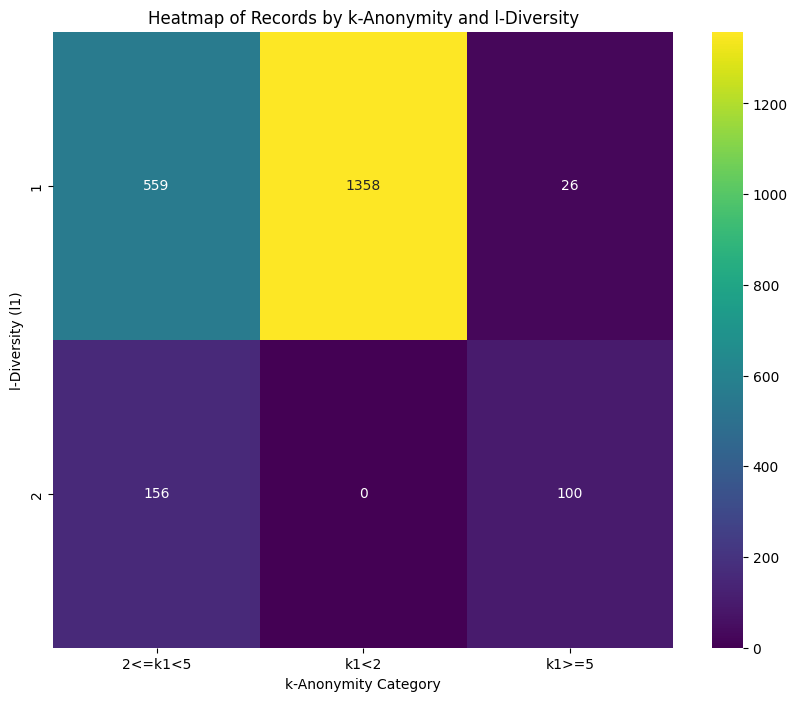

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_mask is already defined and has 'k1' and 'l1' columns calculated

# Define a function to categorize k1 values
def categorize_k1(k1_value):
    if k1_value < 2:
        return 'k1<2'
    elif 2 <= k1_value < 5:
        return '2<=k1<5'
    else:
        return 'k1>=5'

# Apply the function to create a new k1_category column
df_mask['k1_category'] = df_mask['k1'].apply(categorize_k1)

# Create a pivot table for visualization with the new k1 categories
pivot_table = df_mask.pivot_table(index='l1', columns='k1_category', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='d')
plt.title('Heatmap of Records by k-Anonymity and l-Diversity')
plt.xlabel('k-Anonymity Category')
plt.ylabel('l-Diversity (l1)')
plt.show()


####3.3 Расчет потерь информации
Анонимизация исходного набора приводит к потери точности, расчет которой производим по методу NSSD для числовых атрибутов:

In [50]:
import pandas as pd
import numpy as np

# Assuming df_churne and df_mask are already loaded

# Ensure that df_mask is not larger than df_churne
df_mask_aligned = df_mask.iloc[:len(df_churne)]

# Define the columns to compare
columns_churne = ['_AGE', 'CreditScore', 'TotalTxs']  # Adjusted to match the actual column names
columns_mask = ['_AGE', 'creditscore', 'totaltxs']

# Initialize the sum of squared differences
sum_squared_diffs = 0

# Calculate the sum of squared differences for each column
for churne_col, mask_col in zip(columns_churne, columns_mask):
    # Calculate the squared differences
    squared_diffs = (df_churne[churne_col] - df_mask_aligned[mask_col]) ** 2

    # Sum the squared differences
    sum_squared_diffs += squared_diffs.sum()

# Calculate the total number of compared values
n = len(df_churne) * len(columns_churne)

# Calculate the ranges of each column in df_churne and sum their squares
range_squares_sum = sum([(df_churne[col].max() - df_churne[col].min()) ** 2 for col in columns_churne])

# Normalize the sum of squared differences by the number of values and the sum of range squares
nssd = sum_squared_diffs / (n * range_squares_sum) if range_squares_sum > 0 else 0

# Convert NSSD to a percentage for better interpretability
nssd_percentage = nssd * 100

print(f"Normalized Sum of Squared Differences (NSSD): {nssd}")
print(f"Information Loss (%): {nssd_percentage}")

Normalized Sum of Squared Differences (NSSD): 0.047070977246378404
Information Loss (%): 4.7070977246378405


Ниже приводится вывод визуального графика:


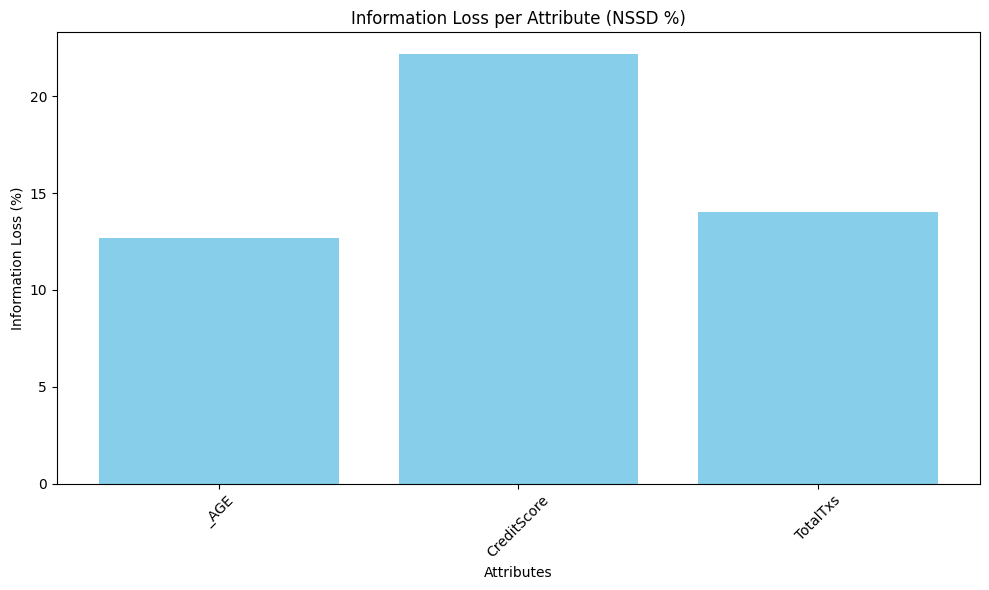

In [51]:

# Define the columns to compare again for clarity
columns_churne = ['_AGE', 'CreditScore', 'TotalTxs']
columns_mask = ['_AGE', 'creditscore', 'totaltxs']

# Initialize a list to store NSSD for each attribute
nssd_values = []

# Calculate the NSSD for each column
for churne_col, mask_col in zip(columns_churne, columns_mask):
    # Calculate the squared differences
    squared_diffs = (df_churne[churne_col] - df_mask_aligned[mask_col]) ** 2
    # Calculate the range of the original column
    value_range = (df_churne[churne_col].max() - df_churne[churne_col].min()) ** 2
    # Normalize the sum of squared differences by the number of values and the range squared
    nssd = squared_diffs.sum() / (len(df_churne) * value_range) if value_range > 0 else 0
    # Store the NSSD value
    nssd_values.append(nssd * 100)  # Convert to percentage

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(columns_churne, nssd_values, color='skyblue')

# Add title and labels
plt.title('Information Loss per Attribute (NSSD %)')
plt.xlabel('Attributes')
plt.ylabel('Information Loss (%)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the bar chart
plt.tight_layout()  # Adjust layout for better fit
plt.show()

####3.4 Рассчет искажения корреляции
Для расчета корреляции будем использовать только числовые значения fnhb,enjd (боллее комплексный подход требует one hot преобразования). Мы будем рассматривать интегральный коэффициент на следующих парах:
- (_AGE - _BALANCR): приведенный возраст - приведенный балланс
- (_AGE - CREDITSCORE): приведенный возраст - кредитный рейтинг
Начнем с построения графиков для первой пары

In [52]:
# Select and output the first few rows for 'ID', 'AGE', and '_BALLANCR' columns from df_mask_aligned
# Assuming that 'AGE' is represented by '_AGE' in df_mask_aligned based on previous context
selected_columns = df_mask.loc[:, ['ID', '_AGE', '_BALLANCR']].head()

print(selected_columns)

   ID  _AGE  _BALLANCR
0   1    22     $50.00
1   2    25  $45750.00
2   3    36  $71400.00
3   4    47  $11200.00
4   5    36  $65550.00


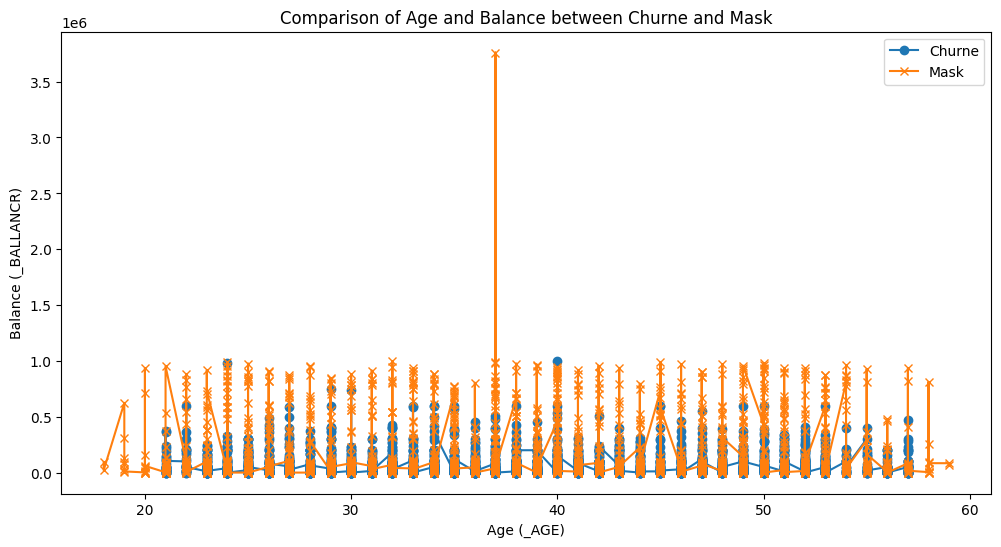

Pearson Correlation Coefficient for Churne: -0.020419145719261574
Pearson Correlation Coefficient for Mask: -0.0004193900478828487
Correlation Loss Metric (CLM): 0.019999755671378724


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets if not already loaded
# df_churne = pd.read_csv('path_to_churne.csv')
# df_mask = pd.read_csv('path_to_mask.csv')

# Assuming df_churne and df_mask are already loaded

# Align df_mask with df_churne based on index if they correspond directly
df_mask_aligned = df_mask.iloc[:len(df_churne)].copy()

# Step 1: Sort the DataFrames by '_AGE'
df_churne_sorted = df_churne.sort_values(by='_AGE').reset_index(drop=True)
df_mask_aligned_sorted = df_mask_aligned.sort_values(by='_AGE').reset_index(drop=True)

# Step 2: Clean the '_BALLANCR' column and build arrays
def clean_and_convert_ballancr(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True)
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce').fillna(0)
    return df

df_churne_sorted = clean_and_convert_ballancr(df_churne_sorted, '_BALLANCR')
df_mask_aligned_sorted = clean_and_convert_ballancr(df_mask_aligned_sorted, '_BALLANCR')

age_churne = df_churne_sorted['_AGE'].values
ballancr_churne = df_churne_sorted['_BALLANCR'].values
age_mask = df_mask_aligned_sorted['_AGE'].values
ballancr_mask = df_mask_aligned_sorted['_BALLANCR'].values

# Step 3: Draw Graphs
plt.figure(figsize=(12, 6))
plt.plot(age_churne, ballancr_churne, label='Churne', marker='o')
plt.plot(age_mask, ballancr_mask, label='Mask', marker='x')
plt.xlabel('Age (_AGE)')
plt.ylabel('Balance (_BALLANCR)')
plt.title('Comparison of Age and Balance between Churne and Mask')
plt.legend()
plt.show()

# Step 4: Calculate Pearson Correlation Coefficient
def calculate_pearson(x, y):
    return np.corrcoef(x, y)[0, 1]

pearson_churne = calculate_pearson(age_churne, ballancr_churne)
pearson_mask = calculate_pearson(age_mask, ballancr_mask)

# Step 5: Calculate CLM and Output
clm = abs(pearson_churne - pearson_mask)
print(f"Pearson Correlation Coefficient for Churne: {pearson_churne}")
print(f"Pearson Correlation Coefficient for Mask: {pearson_mask}")
print(f"Correlation Loss Metric (CLM): {clm}")

Величины смещения корреляции ожидаемо не очень большие. Теперь строим интегральный расчет для CLM на обеих парах:

<Figure size 1000x500 with 0 Axes>

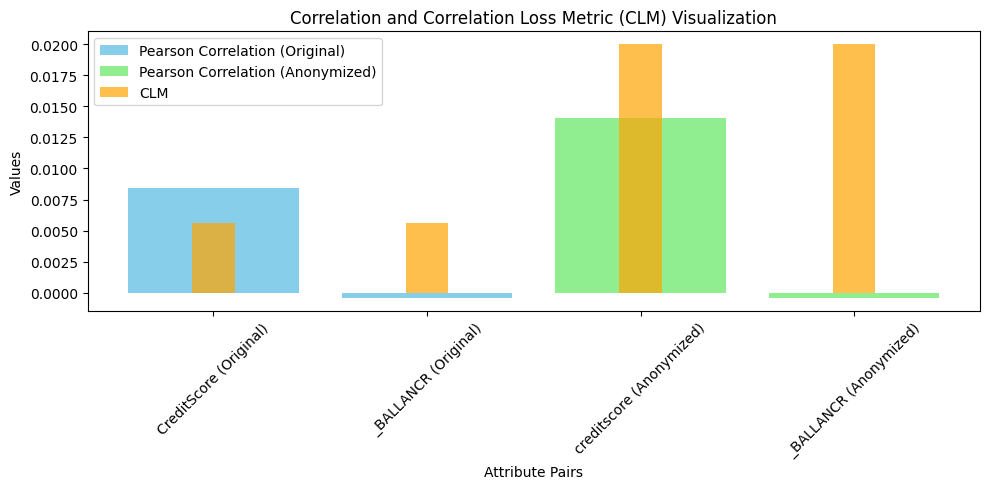

Total CLM: 0.025636987564701633


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to clean and convert monetary and score values to numeric
def clean_and_convert(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True)
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce').fillna(0)
    return df

# Assuming df_churne and df_mask_aligned are already loaded
# Align df_mask with df_churne based on index if they correspond directly
df_mask_aligned = df_mask.iloc[:len(df_churne)].copy()

# Clean and convert the relevant columns
df_churne = clean_and_convert(df_churne, 'CreditScore')
df_churne = clean_and_convert(df_churne, '_BALLANCR')
df_mask_aligned = clean_and_convert(df_mask_aligned, 'creditscore')
df_mask_aligned = clean_and_convert(df_mask_aligned, '_BALLANCR')

# Define the attribute pairs for which to calculate the correlation
attribute_pairs = [
    ('_AGE', 'CreditScore', '_AGE', 'creditscore'),  # Pair 1
    ('_AGE', '_BALLANCR', '_AGE', '_BALLANCR')      # Pair 2
]

# Calculate Pearson correlation coefficients and CLM for each pair
correlations = {}
clms = {}
for pair in attribute_pairs:
    original_corr = df_churne[pair[0]].corr(df_churne[pair[1]])
    anonymized_corr = df_mask_aligned[pair[2]].corr(df_mask_aligned[pair[3]])

    # Store correlations
    correlations[pair[1]] = original_corr
    correlations[pair[3]] = anonymized_corr

    # Calculate and store CLM
    clm = abs(original_corr - anonymized_corr)
    clms[pair[1]] = clm

# Calculate total CLM
total_clm = sum(clms.values())

# Visualization of Correlation and CLM
plt.figure(figsize=(10, 5))

# Labels for both original and anonymized correlations
bar_labels = [f"{pair[1]} (Original)" for pair in attribute_pairs] + \
             [f"{pair[3]} (Anonymized)" for pair in attribute_pairs]

# Correlation values for both original and anonymized data
correlation_values = [correlations[pair[1]] for pair in attribute_pairs] + \
                     [correlations[pair[3]] for pair in attribute_pairs]

# Visualization of Correlation and CLM
plt.figure(figsize=(10, 5))

# Labels for both original and anonymized correlations
bar_labels = [f"{pair[1]} (Original)" for pair in attribute_pairs] + \
             [f"{pair[3]} (Anonymized)" for pair in attribute_pairs]

# Correlation values for both original and anonymized data
correlation_values = [correlations[pair[1]] for pair in attribute_pairs] + \
                     [correlations[pair[3]] for pair in attribute_pairs]

# CLM values need to be repeated for each pair (original and anonymized)
clm_values = [clm for pair in attribute_pairs for clm in (clms[pair[1]], clms[pair[1]])]

# Plot Pearson Correlation for Original and Anonymized
plt.bar(bar_labels[:2], correlation_values[:2], color='skyblue', label='Pearson Correlation (Original)')
plt.bar(bar_labels[2:4], correlation_values[2:4], color='lightgreen', label='Pearson Correlation (Anonymized)')

# Plot CLM overlaid on the Pearson Correlation bars
plt.bar(bar_labels[:2], clm_values[:2], color='orange', label='CLM', width=0.2, alpha=0.7)
plt.bar(bar_labels[2:4], clm_values[2:4], color='orange', width=0.2, alpha=0.7)

plt.title('Correlation and Correlation Loss Metric (CLM) Visualization')
plt.xlabel('Attribute Pairs')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.ylabel('Values')
plt.legend()
plt.tight_layout()  # Adjust layout
plt.show()

# Print the total CLM
print(f"Total CLM: {total_clm}")

Общее смещение корреляции составлет 2%, что представляется обоснованным и соответсвует высокому уровню точности отражения набора.

####3.5 Проведение Linkage атаки
Чтобы выполнить атаку связывания, как описано выше, выполняем следующие действия:
1) Проверяем, что и df_mask, и df_delivery наборах данных есть обязательные столбцы для создания составного ключа (SEX, _AGERANGE, _REGION, PROFESSION).
2) Создаем составной ключ _Link как в df_mask, так и в df_delivery.
3) Создаем словарь из df_delivery, используя _Link в качестве ключа и список идентификаторов в качестве значения.
4) Используем этот словарь, чтобы добавить новый столбец LinkedIndexes в df_mask, в котором хранится список идентификаторов из df_delivery, имеющих соответствующий ключ.
5) Вычисляем вероятность связывания для каждой строки в df_mask.
6) Выводим запрошенные записи и постройте визуализацию.

Number of records with 100% linkage probability: 619
    ID                         fio LinkedIndexes  \
0    1         Ильин Рауф Глебович        [1344]   
2    3  Кречко Татьяна Атаджановна       [29666]   
5    6     Курко Вадим Салаватович       [74450]   
10  11      Щавлев Аслан Оксенович       [17816]   
11  12    Грачева Карина Вадимовна       [26187]   

             FIO_from_df_delivery  
0       Дмитриев Султан Равилевич  
2      Зиновенко Елена Михайловна  
5   Горбунов Евгени Александрович  
10                Шашин Вячеслав   
11     Петухова Ксения Алексеевна  


<ipython-input-55-7f6c0e789a76>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_df['FIO_from_df_delivery'] = matches_df['LinkedIndexes'].apply(lambda x: fio_lookup.get(x[0]) if x else None)


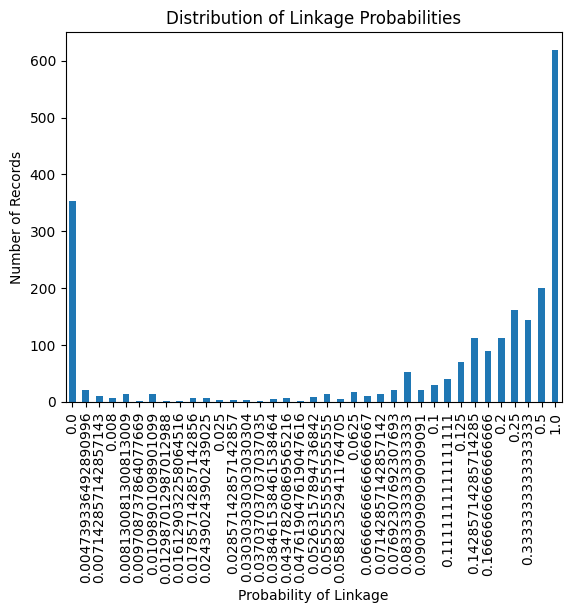

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check if the necessary columns exist
required_columns_mask = ['sex', '_AGERANGE', '_REGION', 'profession']
required_columns_delivery = ['SEX', '_AGERANGE', '_REGION', 'Profession']

# Step 2: Create the composite key '_Link' in both dataframes
df_mask['_Link'] = df_mask['sex'] + ';' + df_mask['_AGERANGE'] + ';' + df_mask['_REGION'] + ';' + df_mask['profession']
df_delivery['_Link'] = df_delivery['SEX'] + ';' + df_delivery['_AGERANGE'] + ';' + df_delivery['_REGION'] + ';' + df_delivery['Profession']

# Step 3: Build a dictionary from df_delivery
link_to_ids_dict = df_delivery.groupby('_Link')['ID'].apply(list).to_dict()

# Step 4: Map the composite key to the linked IDs in df_mask
df_mask['LinkedIndexes'] = df_mask['_Link'].map(link_to_ids_dict)

# Step 5: Calculate the probability of a connection
df_mask['LinkageProbability'] = df_mask['LinkedIndexes'].apply(lambda x: 1.0/len(x) if isinstance(x, list) and len(x) > 0 else 0)

# Step 6: Print the number of records with probability 1.0 and their details
matches_df = df_mask[df_mask['LinkageProbability'] == 1.0]
print(f"Number of records with 100% linkage probability: {matches_df.shape[0]}")

# To get FIO from df_delivery, create a quick lookup dictionary
fio_lookup = df_delivery.set_index('ID')['FIO'].to_dict()

# Match the FIO from df_delivery to the linked ID in df_mask
matches_df['FIO_from_df_delivery'] = matches_df['LinkedIndexes'].apply(lambda x: fio_lookup.get(x[0]) if x else None)

# Print several records as requested
output_columns = ['ID', 'fio', 'LinkedIndexes', 'FIO_from_df_delivery']
print(matches_df[output_columns].head())

# Visualization
# Bar chart showing the distribution of linkage probabilities
prob_counts = df_mask['LinkageProbability'].value_counts().sort_index()
prob_counts.plot(kind='bar', title='Distribution of Linkage Probabilities')
plt.xlabel('Probability of Linkage')
plt.ylabel('Number of Records')
plt.show()

##4. ВЫВОДЫ
Проведенный анализ, расчет метрик  и имитация атак позволяют сделать следующие выводы:
- **Высокий риск повторной идентификации**: Тот факт, что почти 600 записей могут быть связаны с вероятностью 1,0, указывает на высокий риск повторной идентификации. Это говорит о том, что методы анонимизации, примененные к набору df_mask, не были достаточно надежными, чтобы предотвратить связь с внешней информацией, доступной в наборе df_delivery.
- **Неэффективность простых методов анонимизации**: Использование базовых методов анонимизации, таких как «слепая» рандомизация имен, возраста и других прямых идентификаторов, оказалось неэффективным. Без системного подхода к анонимизации, такого как вычисление и контроль уровней k-анонимности и l-разнообразия, обезличенные данные оставались уязвимыми для атак linking.
-**Уязвимость к атакам с изоляцией и связыванием**: атаки с изоляцией (выделение отдельных лиц) и связывание (связывание анонимных данных с внешними источниками данных) были успешными, что свидетельствует об уязвимости используемых методов защиты данных.
-**Качество данных**: качество данных оказалось приемлемым, как по уровню точности, так и по потеряем корреляций, что соответсвует невысокому уровню защиты.

На основании проведенного анализа можно сделать следующие рекомендации о том, как можно усилить защиту данных:
- **Внедрение строгих рамок анонимизации**: Усиление защиты следует проводить за счет внедрения более строгих методов защиты. Расчет таких показателей, как k-анонимность и l-разнесение, и обеспечение их соответствия приемлемым пороговым значениям может значительно снизить риск повторной идентификации.
- **Используйте дифференциальную конфиденциальность**:  дополнительно к рассмотренным классическим способам защиты при исползовании рандомизации (шума) следует рассмотреть возможность использования методов дифференциальной конфиденциальности, которые дают строгие теоретические гарантии риска идентификации отдельных лиц в наборе данных.
- **Методы обезличивания**: следует значительно расширить применяемые методы защиты для произвольных типов полей и возможных сценариев, с рассмотрением различных комбинаций квази-идентификаторов.
- **Регулярно проверяйте стойкость анонимизации**: необходимо проводить регулярные тесты против известных атак, таких как атаки на связь и реконструкцию, чтобы оценить эффективность мер анонимизации.
-**Ограничьте распространение данных**: допонительно стоит ограничить распространение обезличенных наборов данных и делитесь данными только со сторонами, которые придерживаются строгих стандартов защиты данных (организации с низкими контекстными рисками).

Проведенный раунд тестирования не лишен определенных ограничений:
- **Упрощенный сценарий**: Тесты проводились по контролируемому, упрощенному сценарию. Реальные наборы данных и атаки могут быть более сложными и изощренными, что может потребовать более продвинутых защитных мер.
-**Недостаток контекстной информации**: В тестах не учитывался контекст использования данных. Для разных типов данных и контекстов использования могут потребоваться разные методы анонимизации и меры конфиденциальности.
-**Предположение о честных пользователях**: Тест предполагает, что пользователи анонимизированного набора данных честны и не имеют дополнительной информации, которая могла бы облегчить повторную идентификацию.
-**Ограниченные типы данных**: Тест в основном был сосредоточен на прямых идентификаторах и квазиидентификаторах. Другие типы данных, такие как поля с произвольным текстом, сетевые журналы или данные временных рядов, создают дополнительные проблемы с анонимизацией.

**Дополнительные примечания:**
- **Многомерная оценка рисков:** Анонимизация не является универсальным решением. Для эффективной защиты данных необходима многомерная оценка рисков, учитывающая тип данных, потенциальный вред и среду обмена данными.
- **Юридические и этические соображения:** Правовые и этические соображения должны определять процесс анонимизации, обеспечивая соблюдение законов о защите данных, таких как ФЗ-152 или других соответствующих нормативных актов.
